---
# Building out Ensemble Functions
---
- currently in dev
- i am writing out functions for differnt ensemble methods below 


In [1]:
import pandas as pd
import pickle
import random
import numpy as np
import os
import itertools
from joblib import Parallel, delayed ,parallel_backend
from collections import defaultdict
import math
import torch.nn as nn

import Equations_Run_Combo_V_2

from Equations_Run_Combo_V_2 import (

    run_combo,LSTM,
    TimeSeriesDataset,format_to_tensor, train_one_epoch,
    validate_one_epoch, evaluate_binary_0_1, evaluate_signed_neg1_1 ,
)



In [2]:
import pickle
with open('/Users/cs/Desktop/Oil-LSTM-Project-2/short_dfs.pkl', 'rb') as f:
    loaded_dfs = pickle.load(f)

with open("/Users/cs/Desktop/Oil-LSTM-Project-2/lagged_cache.pkl", "rb") as f:
    lagged_cache = pickle.load(f)


****************** STARTED RUN FOR COMBO INDEX 4
--- Running Combo 1 ---Parameters: {'learning_rate': 0.05, 'num_epochs': 150, 'batch_size': 50, 'use_bidirectional': False, 'lag': 3, 'input_size': 12, 'hidden_size': 55, 'num_layers': 1, 'use_monthly_dfs_only': True, 'use_binary_0_1_retRate': False, 'use_binary_neg1_1': False, 'use_ret_rate': False, 'use_print_acc': False, 'use_dropout': False, 'use_class_weighting': False, 'is_deterministic': True, 'seed_num': 9091, 'use_monthly_predictor': False, 'use_existing_lagged_data': True, 'use_dynamic_weights': False, 'use_monthly_daily_end_mo_predictor': False, 'use_monthly_weekly_end_mo_predictor': True, 'use_binary_0_1_retRate_custom_neg': True, 'use_binary_0_1_retRate_custom_pos': False, 'binary_0_1_cutoff_ret_rate_percentage': 0.05, 'end_value_train_set_fraction': 0.85, 'val_set_fraction': 0.1, 'num_folds': 8, 'POS_weight_multiplier': 1, 'use_rolling_fixed_train_size': False, 'use_existing_initial_weights': False, 'state_dict': None}

---

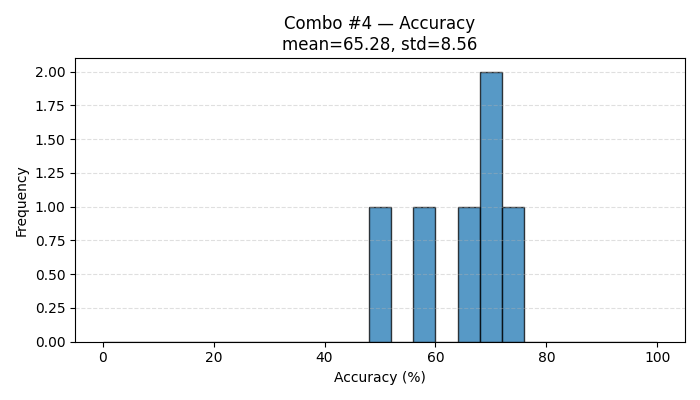

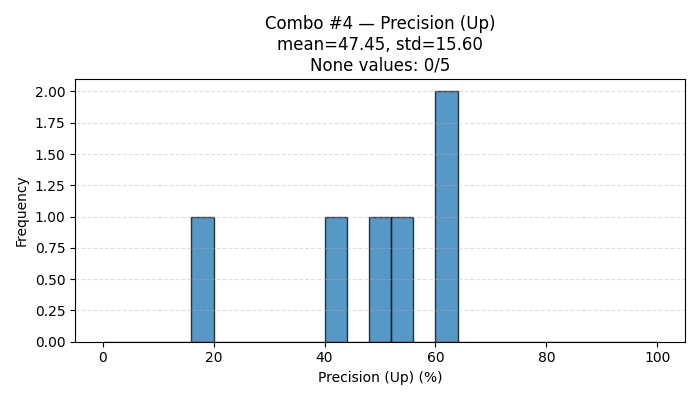

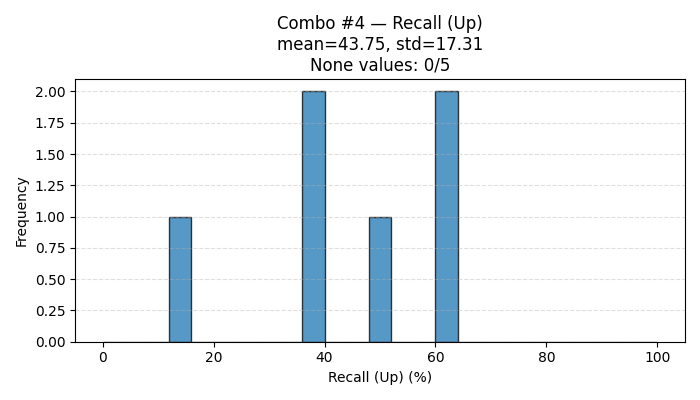

In [4]:

import random, io, base64, math
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed, parallel_backend
from IPython.display import Image, display ; import base64

def distribution_discovery(combo: dict, combo_index: int, number_of_seeds: int):
    """
    Run the same combo across many different seeds by overriding combo['seed_num'].
    Returns three plots (accuracy, precision_up, recall_up) with base64-encoded PNGs.
    Handles None values and records counts of None values in the plots.
    """
    print(f"****************** STARTED RUN FOR COMBO INDEX {combo_index}")

    # choose seeds
    seeds = random.sample(range(10000), number_of_seeds)
    if 42 not in seeds:
        seeds.append(42)

    def run_for_seed(seed_val):
        # override seed in combo (DO NOT mutate original)
        combo_seeded = dict(combo)
        combo_seeded['seed_num'] = seed_val
        combo_seeded['is_deterministic'] = True  # ensure deterministic path uses the provided seed

        # run
        result_entry, w = run_combo(0, combo_seeded, total_offset=0, use_print_acc_vs_pred=False)

        # extract metrics
        try:
            overall_metrics = result_entry['cv_sets']['overall_metrics']
            acc = overall_metrics.get('accuracy', np.nan)
            prec_up = overall_metrics.get('precision_up', np.nan)
            recall_up = overall_metrics.get('recall_up', np.nan)
        except Exception:
            acc, prec_up, recall_up = np.nan, np.nan, np.nan

        return {
            'seed': seed_val,
            'accuracy': float(acc) if acc is not None else np.nan,
            'precision_up': float(prec_up) if prec_up is not None else np.nan,
            'recall_up': float(recall_up) if recall_up is not None else np.nan
        }

    # parallel runs
    with parallel_backend("loky"):
        per_seed = Parallel(n_jobs=4)(delayed(run_for_seed)(s) for s in seeds)

    # Prepare data for plotting
    metrics = {
        'accuracy': {'values': [], 'name': 'Accuracy', 'range': (0, 100)},
        'precision_up': {'values': [], 'name': 'Precision (Up)', 'range': (0, 100)},
        'recall_up': {'values': [], 'name': 'Recall (Up)', 'range': (0, 100)}
    }
    
    # Count None values and collect valid numbers
    none_counts = {'precision_up': 0, 'recall_up': 0}
    for r in per_seed:
        metrics['accuracy']['values'].append(r['accuracy'])
        
        if np.isnan(r['precision_up']):
            none_counts['precision_up'] += 1
        else:
            metrics['precision_up']['values'].append(r['precision_up'])
            
        if np.isnan(r['recall_up']):
            none_counts['recall_up'] += 1
        else:
            metrics['recall_up']['values'].append(r['recall_up'])

    # Calculate stats for each metric
    plots_base64 = {}
    for metric_name, metric_data in metrics.items():
        values = np.array(metric_data['values'], dtype=np.float64)
        valid_values = values[~np.isnan(values)]
        
        if len(valid_values) > 0:
            mean_val = float(np.mean(valid_values))
            std_val = float(np.std(valid_values))
        else:
            mean_val, std_val = float('nan'), float('nan')
        
        # Create plot
        fig = plt.figure(figsize=(7, 4))
        if len(valid_values) > 0:
            plt.hist(valid_values, bins=25, range=metric_data['range'], 
                    edgecolor='black', alpha=0.75)
        
        # Add title and annotations
        title = f"Combo #{combo_index} — {metric_data['name']}\nmean={mean_val:.2f}, std={std_val:.2f}"
        
        # Add None counts for precision and recall
        if metric_name in ['precision_up', 'recall_up']:
            title += f"\nNone values: {none_counts[metric_name]}/{number_of_seeds}"
        
        plt.title(title)
        plt.xlabel(f"{metric_data['name']} (%)")
        plt.ylabel("Frequency")
        plt.grid(axis='y', linestyle='--', alpha=0.4)
        plt.tight_layout()

        # Save to base64
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)
        plots_base64[metric_name] = base64.b64encode(buf.read()).decode('utf-8')
        plt.close(fig)

    return {
        'combo_index': combo_index,
        'combo': combo,
        'per_seed': per_seed,
        'none_counts': none_counts,
        'plots_base64': plots_base64,
    }


c = {'learning_rate': 0.05, 'num_epochs': 150, 'batch_size': 50, 'use_bidirectional': False, 'lag': 3, 'input_size': 12, 'hidden_size': 55, 'num_layers': 1, 'use_monthly_dfs_only': True, 'use_binary_0_1_retRate': False, 'use_binary_neg1_1': False, 'use_ret_rate': False, 'use_print_acc': False, 'use_dropout': False, 'use_class_weighting': False, 'is_deterministic': True, 'seed_num': 42, 'use_monthly_predictor': False, 'use_existing_lagged_data': True, 'use_dynamic_weights': False, 'use_monthly_daily_end_mo_predictor': False, 'use_monthly_weekly_end_mo_predictor': True, 'use_binary_0_1_retRate_custom_neg': True, 'use_binary_0_1_retRate_custom_pos': False, 'binary_0_1_cutoff_ret_rate_percentage': 0.05, 'end_value_train_set_fraction': 0.85, 'val_set_fraction': 0.1, 'num_folds': 8, 'POS_weight_multiplier': 1, 'use_rolling_fixed_train_size': False, 'use_existing_initial_weights': False, 'state_dict': None}

# Example usage
res = distribution_discovery(c, combo_index=4, number_of_seeds=5)

# To display the images:
for metric in ['accuracy', 'precision_up', 'recall_up']:
    image_data = base64.b64decode(res["plots_base64"][metric])
    display(Image(data=image_data))

In [27]:
# from IPython.display import Image, display ; import base64

# # To display the images:
# for metric in ['accuracy', 'precision_up', 'recall_up']:
#     image_data = base64.b64decode(res["plots_base64"][metric])
#     display(Image(data=image_data))

In [ ]:
# import pickle

# with open("pair_params_maps.pkl", "rb") as f:
#     loaded_pair_maps = pickle.load(f)

# # Example: access one of them
# print(loaded_pair_maps["pair_params_map_2_neg01_00"])


{(6, 19): [{'learning_rate': 0.005, 'num_epochs': 150, 'batch_size': 30, 'use_bidirectional': False, 'lag': 6, 'input_size': 12, 'hidden_size': 35, 'num_layers': 4, 'use_monthly_dfs_only': True, 'use_binary_0_1_retRate': False, 'use_binary_neg1_1': False, 'use_ret_rate': False, 'use_print_acc': False, 'use_dropout': True, 'use_class_weighting': True, 'is_deterministic': True, 'seed_num': 42, 'use_monthly_predictor': False, 'use_existing_lagged_data': True, 'use_dynamic_weights': False, 'use_monthly_daily_end_mo_predictor': False, 'use_monthly_weekly_end_mo_predictor': True, 'use_binary_0_1_retRate_custom_neg': True, 'use_binary_0_1_retRate_custom_pos': False, 'binary_0_1_cutoff_ret_rate_percentage': 0.05, 'end_value_train_set_fraction': 0.85, 'val_set_fraction': 0.1, 'num_folds': 8, 'POS_weight_multiplier': 0.7, 'use_rolling_fixed_train_size': False, 'use_existing_initial_weights': False, 'state_dict': None}, {'learning_rate': 0.0005, 'num_epochs': 300, 'batch_size': 70, 'use_bidirecti

In [ ]:
from joblib import parallel_backend , Parallel




combo_list = [
    
{'learning_rate': 0.0005, 'num_epochs': 150, 'batch_size': 30, 'use_bidirectional': False, 'lag': 6, 'input_size': 12, 'hidden_size': 35, 'num_layers': 2, 'use_monthly_dfs_only': True, 'use_binary_0_1_retRate': False, 'use_binary_neg1_1': False, 'use_ret_rate': False, 'use_print_acc': False, 'use_dropout': True, 'use_class_weighting': False, 'is_deterministic': True, 'seed_num': 42, 'use_monthly_predictor': False, 'use_existing_lagged_data': True, 'use_dynamic_weights': False, 'use_monthly_daily_end_mo_predictor': False, 'use_monthly_weekly_end_mo_predictor': True, 'use_binary_0_1_retRate_custom_neg': True, 'use_binary_0_1_retRate_custom_pos': False, 'binary_0_1_cutoff_ret_rate_percentage': 0.05, 'end_value_train_set_fraction': 0.85, 'val_set_fraction': 0.1, 'num_folds': 8, 'POS_weight_multiplier': 1, 'use_rolling_fixed_train_size': False, 'use_existing_initial_weights': False, 'state_dict': None}
, 

{'learning_rate': 0.0005, 'num_epochs': 300, 'batch_size': 50, 'use_bidirectional': False, 'lag': 6, 'input_size': 12, 'hidden_size': 55, 'num_layers': 4, 'use_monthly_dfs_only': True, 'use_binary_0_1_retRate': False, 'use_binary_neg1_1': False, 'use_ret_rate': False, 'use_print_acc': False, 'use_dropout': False, 'use_class_weighting': False, 'is_deterministic': True, 'seed_num': 42, 'use_monthly_predictor': False, 'use_existing_lagged_data': True, 'use_dynamic_weights': False, 'use_monthly_daily_end_mo_predictor': False, 'use_monthly_weekly_end_mo_predictor': True, 'use_binary_0_1_retRate_custom_neg': True, 'use_binary_0_1_retRate_custom_pos': False, 'binary_0_1_cutoff_ret_rate_percentage': 0.05, 'end_value_train_set_fraction': 0.85, 'val_set_fraction': 0.1, 'num_folds': 8, 'POS_weight_multiplier': 1.3, 'use_rolling_fixed_train_size': False, 'use_existing_initial_weights': False, 'state_dict': None}
,

{'learning_rate': 0.05, 'num_epochs': 150, 'batch_size': 50, 'use_bidirectional': False, 'lag': 3, 'input_size': 12, 'hidden_size': 55, 'num_layers': 1, 'use_monthly_dfs_only': True, 'use_binary_0_1_retRate': False, 'use_binary_neg1_1': False, 'use_ret_rate': False, 'use_print_acc': False, 'use_dropout': False, 'use_class_weighting': False, 'is_deterministic': True, 'seed_num': 42, 'use_monthly_predictor': False, 'use_existing_lagged_data': True, 'use_dynamic_weights': False, 'use_monthly_daily_end_mo_predictor': False, 'use_monthly_weekly_end_mo_predictor': True, 'use_binary_0_1_retRate_custom_neg': True, 'use_binary_0_1_retRate_custom_pos': False, 'binary_0_1_cutoff_ret_rate_percentage': 0.05, 'end_value_train_set_fraction': 0.85, 'val_set_fraction': 0.1, 'num_folds': 8, 'POS_weight_multiplier': 1, 'use_rolling_fixed_train_size': False, 'use_existing_initial_weights': False, 'state_dict': None}

# ,
# {'learning_rate': 0.0005, 'num_epochs': 700, 'batch_size': 10, 'use_bidirectional': False, 'lag': 6, 'input_size': 12, 'hidden_size': 12, 'num_layers': 2, 'use_monthly_dfs_only': True, 'use_binary_0_1_retRate': False, 'use_binary_neg1_1': False, 'use_ret_rate': False, 'use_print_acc': False, 'use_dropout': True, 'use_class_weighting': False, 'is_deterministic': True, 'seed_num': 42, 'use_monthly_predictor': False, 'use_existing_lagged_data': True, 'use_dynamic_weights': False, 'use_monthly_daily_end_mo_predictor': False, 'use_monthly_weekly_end_mo_predictor': True, 'use_binary_0_1_retRate_custom_neg': True, 'use_binary_0_1_retRate_custom_pos': False, 'binary_0_1_cutoff_ret_rate_percentage': 0.05, 'end_value_train_set_fraction': 0.85, 'val_set_fraction': 0.1, 'num_folds': 8, 'POS_weight_multiplier': 1, 'use_rolling_fixed_train_size': True, 'use_existing_initial_weights': False, 'state_dict': None}
]

def avg_ensemble(combo_list , num_cv_sets , total_offset , INDEX):

    # print('runnign combo -- ' , total_offset + INDEX)

    with parallel_backend("loky", n_jobs=-1):
        all_results  = Parallel()(
            delayed(run_combo)(i, combo, 10, use_print_acc_vs_pred=False)
            for i, combo in enumerate(combo_list)
        )

    results, weights  = zip(*all_results)

    all_model_preds = [res["all_preds"] for res in results]  # shape: (num_models, num_folds)

    transposed_preds = list(zip(*all_model_preds))  # shape: (num_folds, num_models)


    avg_preds_per_fold = [np.mean(np.stack(preds), axis=0) for preds in transposed_preds]

    predictions_folds  = avg_preds_per_fold
    actuals_folds = results[0]["all_actuals"]
    raw_actuals = results[0]["raw_actuals"]

    cv_data = {}  

    for set_idx , (pred_fold,act_fold) in enumerate(zip(predictions_folds , actuals_folds )):
        
        metrics = evaluate_binary_0_1(pred_fold, act_fold, one_fold=True , do_print=False)
        
        cv_data[f"set_{set_idx + 1}"] = metrics


    # === Compute overall average ===
    metrics_keys = cv_data[f"set_{set_idx + 1}"].keys()

    overall_avg = {}
    for k in metrics_keys:
        values = [cv_data[f"set_{i + 1}"][k] for i in range(num_cv_sets)]

        numeric_values = [v for v in values if v is not None and not (isinstance(v, float) and np.isnan(v)) and isinstance(v, (int, float))]
        if len(numeric_values) > 0:
            overall_avg[k] = np.mean(numeric_values)

        else:
            overall_avg[k] = None

    cv_data["avg_across_all_sets"] = overall_avg

        # --- NEW: overall metrics across ALL folds (handles "no agreement")
    # flat_preds   = [p for fold in predictions_folds for p in fold]
    # flat_actuals = [a for fold in actuals_folds     for a in fold]
    cv_data["overall_metrics"] = evaluate_binary_0_1(predictions_folds, actuals_folds, one_fold=False, do_print=False)

    result_entry = {
        "combo_number": total_offset + INDEX + 1,
        "parameters": combo_list,
        "cv_sets": cv_data,
        "all_preds" : predictions_folds ,
        "all_actuals" : actuals_folds,
        "raw_actuals" : raw_actuals

    }

    

    return result_entry

avg_ensemble(combo_list , num_cv_sets = 8 , total_offset  = 1, INDEX = 1)



In [22]:




from joblib import parallel_backend , Parallel



def evaluate_binary_0_1_selective_ensemble(predicted_array, actual_array,do_print : bool):

    predicted_array_correction = []
    actual_array_correction = []
    
    
    for idx, (pred,act) in enumerate(zip(predicted_array,actual_array)):
        if not isinstance(pred, str) and not None :
            predicted_array_correction.append(pred)
            actual_array_correction.append(act)

    print(predicted_array_correction)
    # print(predicted_array_correction)
    # print(actual_array_correction)


    # if predicted_array_correction == [] or None:
    if not predicted_array_correction:


        return {
        'accuracy': 'No Agreed Predictions',
        'precision_up': 'No Agreed Predictions',
        'recall_up': 'No Agreed Predictions',
        'precision_down': 'No Agreed Predictions',
        'recall_down': 'No Agreed Predictions',
    }
    
    else:

        predicted_array_correction = [i for i in predicted_array_correction]
        actual_array_correction = [i for i in actual_array_correction]

        predicted_array_correction = np.array(predicted_array_correction)
        actual_array_correction = np.array(actual_array_correction)

        pred_direction = (predicted_array_correction > 0.5).astype(int)
        actual_direction = (actual_array_correction > 0.5).astype(int)
        correct = (pred_direction == actual_direction).astype(int)
        
        accuracy = correct.sum() / len(correct) * 100
        actual_ups = (actual_direction == 1)
        predicted_ups = (pred_direction == 1)
        true_positives_up = (predicted_ups & actual_ups).sum()
        precision_up = true_positives_up / predicted_ups.sum() * 100 if predicted_ups.sum() > 0 else float('nan')
        recall_up = true_positives_up / actual_ups.sum() * 100 if actual_ups.sum() > 0 else float('nan')
        actual_downs = (actual_direction == 0)
        predicted_downs = (pred_direction == 0)
        true_positives_down = (predicted_downs & actual_downs).sum()
        precision_down = true_positives_down / predicted_downs.sum() * 100 if predicted_downs.sum() > 0 else float('nan')
        recall_down = true_positives_down / actual_downs.sum() * 100 if actual_downs.sum() > 0 else float('nan')

        if actual_ups.sum() == 0 and predicted_ups.sum() == 0:
            precision_up = None
            recall_up = None

        if actual_ups.sum() == 0 and predicted_ups.sum() > 0:
            precision_up = 0
            recall_up = None      

        if actual_ups.sum() > 0 and predicted_ups.sum() == 0:
            precision_up = None
            recall_up = 0

            ####################################

        if actual_downs.sum() == 0 and predicted_downs.sum() == 0:
            precision_down = None
            recall_down = None

        if actual_downs.sum() == 0 and predicted_downs.sum() > 0:
            precision_down = 0
            recall_down = None
        
        if actual_downs.sum() > 0 and predicted_downs.sum() == 0:
            precision_down = None
            recall_down = 0


        # if do_print:
        #     print(f"Directional Accuracy: {accuracy:.2f}%")
        #     print(f'Up Precision: {precision_up:.2f}%')
        #     print(f'Up Recall:    {recall_up:.2f}%')
        #     print(f'Down Precision: {precision_down:.2f}%')
        #     print(f'Down Recall:    {recall_down:.2f}%')
        return {
            'accuracy': accuracy,
            'precision_up': precision_up,
            'recall_up': recall_up,
            'precision_down': precision_down,
            'recall_down': recall_down,
        }




combo_list = [
    
{'learning_rate': 0.0005, 'num_epochs': 150, 'batch_size': 30, 'use_bidirectional': False, 'lag': 6, 'input_size': 12, 'hidden_size': 35, 'num_layers': 2, 'use_monthly_dfs_only': True, 'use_binary_0_1_retRate': False, 'use_binary_neg1_1': False, 'use_ret_rate': False, 'use_print_acc': False, 'use_dropout': True, 'use_class_weighting': False, 'is_deterministic': True, 'seed_num': 42, 'use_monthly_predictor': False, 'use_existing_lagged_data': True, 'use_dynamic_weights': False, 'use_monthly_daily_end_mo_predictor': False, 'use_monthly_weekly_end_mo_predictor': True, 'use_binary_0_1_retRate_custom_neg': True, 'use_binary_0_1_retRate_custom_pos': False, 'binary_0_1_cutoff_ret_rate_percentage': 0.05, 'end_value_train_set_fraction': 0.95, 'val_set_fraction': 0.05, 'num_folds': 4, 'POS_weight_multiplier': 1, 'use_rolling_fixed_train_size': False, 'use_existing_initial_weights': False, 'state_dict': None}
,

{'learning_rate': 0.0005, 'num_epochs': 300, 'batch_size': 10, 'use_bidirectional': False, 'lag': 6, 'input_size': 12, 'hidden_size': 12, 'num_layers': 2, 'use_monthly_dfs_only': True, 'use_binary_0_1_retRate': False, 'use_binary_neg1_1': False, 'use_ret_rate': False, 'use_print_acc': False, 'use_dropout': False, 'use_class_weighting': False, 'is_deterministic': True, 'seed_num': 42, 'use_monthly_predictor': False, 'use_existing_lagged_data': True, 'use_dynamic_weights': False, 'use_monthly_daily_end_mo_predictor': False, 'use_monthly_weekly_end_mo_predictor': True, 'use_binary_0_1_retRate_custom_neg': True, 'use_binary_0_1_retRate_custom_pos': False, 'binary_0_1_cutoff_ret_rate_percentage': 0.05, 'end_value_train_set_fraction': 0.95, 'val_set_fraction': 0.05, 'num_folds': 4, 'POS_weight_multiplier': 1, 'use_rolling_fixed_train_size': False, 'use_existing_initial_weights': False, 'state_dict': None}
,
{'learning_rate': 0.0005, 'num_epochs': 300, 'batch_size': 50, 'use_bidirectional': False, 'lag': 6, 'input_size': 12, 'hidden_size': 20, 'num_layers': 2, 'use_monthly_dfs_only': True, 'use_binary_0_1_retRate': False, 'use_binary_neg1_1': False, 'use_ret_rate': False, 'use_print_acc': False, 'use_dropout': True, 'use_class_weighting': False, 'is_deterministic': True, 'seed_num': 42, 'use_monthly_predictor': False, 'use_existing_lagged_data': True, 'use_dynamic_weights': False, 'use_monthly_daily_end_mo_predictor': False, 'use_monthly_weekly_end_mo_predictor': True, 'use_binary_0_1_retRate_custom_neg': True, 'use_binary_0_1_retRate_custom_pos': False, 'binary_0_1_cutoff_ret_rate_percentage': 0.05, 'end_value_train_set_fraction': 0.95, 'val_set_fraction': 0.05, 'num_folds': 4, 'POS_weight_multiplier': 0.7, 'use_rolling_fixed_train_size': True, 'use_existing_initial_weights': False, 'state_dict': None}

]

def selective_ensemble_all_agree(combo_list , num_cv_sets , total_offset , INDEX) : 


    with parallel_backend("loky", n_jobs=-1):
        all_results  = Parallel()(
            delayed(run_combo)(i, combo, 0, use_print_acc_vs_pred=False)
            for i, combo in enumerate(combo_list)
        )

    results, weights  = zip(*all_results)

    all_model_preds = [res["all_preds"] for res in results]  # shape: (num_models, num_folds)


    transposed_preds = list(zip(*all_model_preds))  
    stacked = [np.stack(i) for i in transposed_preds]
    stacked_bool_int = [(array > 0.5).astype(int) for array in stacked]
    predictions_folds = []

    for fold in stacked_bool_int:
        
        agreement = (fold == fold[0]).all(axis=0)  
        agreed_vals = fold[0]  
    
        result = [
            agreed_vals[i] if agreement[i] else "no agreement"
            for i in range(fold.shape[1])
        ]
        
        predictions_folds.append(result)

    actuals_folds = results[0]["all_actuals"]
    raw_actuals_folds = results[0]["raw_actuals"]


    cv_data = {}  

    for set_idx , (pred_fold,act_fold) in enumerate(zip(predictions_folds , actuals_folds )):
        
        metrics = evaluate_binary_0_1_selective_ensemble(pred_fold, act_fold , do_print=False)
        
        cv_data[f"set_{set_idx + 1}"] = metrics       
        
    print(cv_data)                              ############### NOTE NOTE STILL NEED TO FIX METRICS TO MAKE SURE STINGS ARE TREATED PROPERLY 


    metrics_keys = cv_data[f"set_{set_idx + 1}"].keys()

    overall_avg = {}
    for k in metrics_keys:
        values = [cv_data[f"set_{i + 1}"][k] for i in range(num_cv_sets)]

        numeric_values = [v for v in values if v is not None and not (isinstance(v, float) and np.isnan(v)) and isinstance(v, (int, float))]
        if len(numeric_values) > 0:
            overall_avg[k] = np.mean(numeric_values)

        else:
            overall_avg[k] = None

    cv_data["avg_across_all_sets"] = overall_avg

        # --- NEW: overall metrics across ALL folds (handles "no agreement")
    flat_preds   = [p for fold in predictions_folds for p in fold]
    flat_actuals = [a for fold in actuals_folds     for a in fold]
    cv_data["overall_metrics"] = evaluate_binary_0_1_selective_ensemble(flat_preds, flat_actuals , do_print=False)


    result_entry = {
            "combo_number": total_offset + INDEX + 1,
            "parameters": combo_list,
            "cv_sets": cv_data,
            "all_preds" : predictions_folds ,
            "all_actuals" : actuals_folds,
            "raw_actuals" : raw_actuals_folds }

    return result_entry




--- Running Combo 11 ---Parameters: {'learning_rate': 0.0005, 'num_epochs': 150, 'batch_size': 30, 'use_bidirectional': False, 'lag': 6, 'input_size': 12, 'hidden_size': 35, 'num_layers': 2, 'use_monthly_dfs_only': True, 'use_binary_0_1_retRate': False, 'use_binary_neg1_1': False, 'use_ret_rate': False, 'use_print_acc': False, 'use_dropout': True, 'use_class_weighting': False, 'is_deterministic': True, 'seed_num': 42, 'use_monthly_predictor': False, 'use_existing_lagged_data': True, 'use_dynamic_weights': False, 'use_monthly_daily_end_mo_predictor': False, 'use_monthly_weekly_end_mo_predictor': True, 'use_binary_0_1_retRate_custom_neg': True, 'use_binary_0_1_retRate_custom_pos': False, 'binary_0_1_cutoff_ret_rate_percentage': 0.05, 'end_value_train_set_fraction': 0.95, 'val_set_fraction': 0.05, 'num_folds': 4, 'POS_weight_multiplier': 1, 'use_rolling_fixed_train_size': False, 'use_existing_initial_weights': False, 'state_dict': None}

--- Running Combo 13 ---Parameters: {'learning_rate

{'combo_number': 1,
 'parameters': [{'learning_rate': 0.0005,
   'num_epochs': 150,
   'batch_size': 30,
   'use_bidirectional': False,
   'lag': 6,
   'input_size': 12,
   'hidden_size': 35,
   'num_layers': 2,
   'use_monthly_dfs_only': True,
   'use_binary_0_1_retRate': False,
   'use_binary_neg1_1': False,
   'use_ret_rate': False,
   'use_print_acc': False,
   'use_dropout': True,
   'use_class_weighting': False,
   'is_deterministic': True,
   'seed_num': 42,
   'use_monthly_predictor': False,
   'use_existing_lagged_data': True,
   'use_dynamic_weights': False,
   'use_monthly_daily_end_mo_predictor': False,
   'use_monthly_weekly_end_mo_predictor': True,
   'use_binary_0_1_retRate_custom_neg': True,
   'use_binary_0_1_retRate_custom_pos': False,
   'binary_0_1_cutoff_ret_rate_percentage': 0.05,
   'end_value_train_set_fraction': 0.95,
   'val_set_fraction': 0.05,
   'num_folds': 4,
   'POS_weight_multiplier': 1,
   'use_rolling_fixed_train_size': False,
   'use_existing_initial

In [ ]:
def selective_ensemble_threshold_agreement(combo_list, num_cv_sets, total_offset, INDEX, threshold_fraction=0.7): 
    """
    Ensemble that only makes predictions when a threshold fraction of models agree.
    
    Args:
        combo_list: List of model configurations
        num_cv_sets: Number of cross-validation sets
        total_offset: Offset for combo numbering
        INDEX: Current index
        threshold_fraction: Minimum fraction of models that must agree (default: 0.7)
        
    Returns:
        Dictionary with results similar to selective_ensemble_all_agree
    """
    
    with parallel_backend("loky", n_jobs=-1):
        all_results = Parallel()(
            delayed(run_combo)(i, combo, 0, use_print_acc_vs_pred=False)
            for i, combo in enumerate(combo_list)
        )

    results, weights = zip(*all_results)
    all_model_preds = [res["all_preds"] for res in results]  # shape: (num_models, num_folds)

    transposed_preds = list(zip(*all_model_preds))  
    stacked = [np.stack(i) for i in transposed_preds]
    stacked_bool_int = [(array > 0.5).astype(int) for array in stacked]
    predictions_folds = []
    
    num_models = len(combo_list)
    threshold_count = int(np.ceil(num_models * threshold_fraction))

    for fold in stacked_bool_int:
        # Count votes for each class (0 and 1)
        vote_count_1 = fold.sum(axis=0)  # how many models predicted 1
        vote_count_0 = num_models - vote_count_1  # how many predicted 0
        
        # Determine if either class meets the threshold
        meets_threshold_1 = (vote_count_1 >= threshold_count)
        meets_threshold_0 = (vote_count_0 >= threshold_count)
        
        # Create final predictions
        result = []
        for i in range(fold.shape[1]):
            if meets_threshold_1[i]:
                result.append(1)
            elif meets_threshold_0[i]:
                result.append(0)
            else:
                result.append("no agreement")
                
        predictions_folds.append(result)

    actuals_folds = results[0]["all_actuals"]
    raw_actuals_folds = results[0]["raw_actuals"]

    cv_data = {}  

    for set_idx, (pred_fold, act_fold) in enumerate(zip(predictions_folds, actuals_folds)):
        metrics = evaluate_binary_0_1_selective_ensemble(pred_fold, act_fold, do_print=False)
        cv_data[f"set_{set_idx + 1}"] = metrics       
        
    # Calculate average metrics across all sets
    metrics_keys = cv_data[f"set_{set_idx + 1}"].keys()
    overall_avg = {}
    for k in metrics_keys:
        values = [cv_data[f"set_{i + 1}"][k] for i in range(num_cv_sets)]
        numeric_values = [v for v in values if v is not None and 
                         not (isinstance(v, float) and np.isnan(v)) and 
                         isinstance(v, (int, float))]
        overall_avg[k] = np.mean(numeric_values) if numeric_values else None

    cv_data["avg_across_all_sets"] = overall_avg

    # Calculate overall metrics across ALL folds
    flat_preds = [p for fold in predictions_folds for p in fold]
    flat_actuals = [a for fold in actuals_folds for a in fold]
    cv_data["overall_metrics"] = evaluate_binary_0_1_selective_ensemble(
        flat_preds, flat_actuals, do_print=False)

    result_entry = {
        "combo_number": total_offset + INDEX + 1,
        "parameters": combo_list,
        "threshold_fraction": threshold_fraction,
        "cv_sets": cv_data,
        "all_preds": predictions_folds,
        "all_actuals": actuals_folds,
        "raw_actuals": raw_actuals_folds
    }

    return result_entry

In [ ]:


def selective_ensemble_majority_vote(combo_list ,  total_offset , INDEX): 

    with parallel_backend("loky", n_jobs=-1):
        all_results = Parallel()(
            delayed(run_combo)(i, combo, 0, use_print_acc_vs_pred=False)
            for i, combo in enumerate(combo_list)
        )

    results, weights = zip(*all_results)
    all_model_preds = [res["all_preds"] for res in results]  # shape: (num_models, num_folds)

    transposed_preds = list(zip(*all_model_preds))  # shape: (num_folds, num_models)
    stacked = [np.stack(i) for i in transposed_preds]  # shape: (num_models, num_samples) per fold
    stacked_bool_int = [(array > 0.5).astype(int) for array in stacked]  # binarize

    predictions_folds = []

    for fold in stacked_bool_int:
        # fold: shape (num_models, num_samples)
        num_models = fold.shape[0]
        vote_count_1 = fold.sum(axis=0)  # how many models predicted 1
        vote_count_0 = num_models - vote_count_1
        final_vote_fold = (vote_count_1 > vote_count_0).astype(int)

        predictions_folds.append(final_vote_fold)

    actuals_folds = results[0]["all_actuals"]
    raw_actuals_folds = results[0]["raw_actuals"]

    cv_data = {}  

    for set_idx, (pred_fold, act_fold) in enumerate(zip(predictions_folds, actuals_folds)):
        metrics = evaluate_binary_0_1(pred_fold, act_fold, one_fold= True , do_print=False)
        cv_data[f"set_{set_idx + 1}"] = metrics

    metrics_keys = cv_data[f"set_{set_idx + 1}"].keys()
    num_cv_sets = 8
    overall_avg = {}
    for k in metrics_keys:
        values = [cv_data[f"set_{i + 1}"][k] for i in range(num_cv_sets)]
        numeric_values = [v for v in values if v is not None and not (isinstance(v, float) and np.isnan(v)) and isinstance(v, (int, float))]
        overall_avg[k] = np.mean(numeric_values) if numeric_values else None

    cv_data["avg_across_all_sets"] = overall_avg

        # --- NEW: overall metrics across ALL folds (handles "no agreement")
    flat_preds   = [p for fold in predictions_folds for p in fold]
    flat_actuals = [a for fold in actuals_folds     for a in fold]
    cv_data["overall_metrics"] = evaluate_binary_0_1(flat_preds, flat_actuals,one_fold= False , do_print=False)


    result_entry = {
            "combo_number": total_offset + INDEX + 1,
            "parameters": combo_list,
            "cv_sets": cv_data,
            "all_preds" : predictions_folds ,
            "all_actuals" : actuals_folds,
            "raw_actuals" : raw_actuals_folds }

    return result_entry


In [ ]:
# x = [0 , 5 , 0]
# x = np.array(x)

# a = (x > .1).astype(int)

# a
# # np.array([0 , 5 , 0]).flatten()

# # t =[1. , 2.]

# # [int(i) for i in t]

# if not isinstance('hi', str) or not None :
#     print('xx')



xx


[4]

In [ ]:


# values = [None , 'hi' , 4 ]
# [v for v in values if v and isinstance(v, (int, float))]
np.mean(np.stack(transposed_preds[0]))
transposed_preds[0]


# transposed_preds

# print(*all_model_preds)

# all_model_preds

# for i in list(zip(*all_model_preds)):
#     print(np.mean(np.stack(i) , axis = 0))

# [np.mean(np.stack(i) , axis = 0) for i in transposed_preds]




# [np.stack(i) for i in transposed_preds] 

# for i in [np.stack(i) for i in transposed_preds] : 
#     print((i > 0.5).astype(int))


stacked = [np.stack(i) for i in transposed_preds]

stacked_bool_int = [(array > 0.5).astype(int) for array in stacked]

# value  = []

# for i in stacked_bool_int:
#     print(i)

# actuals_folds



final_results = []

for fold in stacked_bool_int:
    # fold: list of arrays → convert to 2D NumPy array
    fold_array = np.array(fold)  # shape: (num_models, num_samples)
    
    agreement = (fold_array == fold_array[0]).all(axis=0)  # shape: (num_samples,)
    agreed_vals = fold_array[0]  # use first model's values when they agree
    
    result = [
        agreed_vals[i] if agreement[i] else "no agreement"
        for i in range(fold_array.shape[1])
    ]
    
    final_results.append(result)

# Now final_results is a list of lists, one per fold, with agreed predictions or 'no agreement'

final_results

[[np.int64(0), np.int64(0), np.int64(0)],
 [np.int64(1), np.int64(1), np.int64(1)],
 [np.int64(0), np.int64(0), np.int64(0)],
 [np.int64(0), np.int64(0), np.int64(0)],
 [np.int64(0), np.int64(0), np.int64(0)],
 [np.int64(0), np.int64(0), np.int64(0)],
 [np.int64(0), np.int64(0), np.int64(0)],
 [np.int64(0), np.int64(0), np.int64(0)]]

In [ ]:

# # import pickle
# # with open('/Users/cs/Desktop/Oil-LSTM-Project-2/short_dfs.pkl', 'rb') as f:
# #     loaded_dfs = pickle.load(f)

# # with open("/Users/cs/Desktop/Oil-LSTM-Project-2/lagged_cache.pkl", "rb") as f:
# #     lagged_cache = pickle.load(f)

# print(    zip(*[[([0.35196134, 0.35294414, 0.35071504]),

#   ([0.49098682, 0.4896257 , 0.49176097])],


#  [([0.35196134, 0.35294414, 0.35071504]),
#   ([0.49098682, 0.4896257 , 0.49176097])]])    )

# for i in  zip(*[[([0.35196134, 0.35294414, 0.35071504]),

#   ([0.49098682, 0.4896257 , 0.49176097])],


#  [([0.35196134, 0.35294414, 0.35071504]),
#   ([0.49098682, 0.4896257 , 0.49176097])]]) :
    
#     print(i)


# # [[0.35196134, 0.35294414, 0.35071504], [0.49098682, 0.4896257, 0.49176097]] [[0.35196134, 0.35294414, 0.35071504], [0.49098682, 0.4896257, 0.49176097]]



([0.35196134, 0.35294414, 0.35071504], [0.35196134, 0.35294414, 0.35071504])
([0.49098682, 0.4896257, 0.49176097], [0.49098682, 0.4896257, 0.49176097])


In [ ]:

np.mean(np.stack(transposed_preds[0]))
transposed_preds[0]


transposed_preds

# print(*all_model_preds)

# all_model_preds

# # transposed_preds


# # [array([0.35196134, 0.35294414, 0.35071504], dtype=float32), array([0.5908626 , 0.58940774, 0.591642  ], dtype=float32), array([0.48835257, 0.48888263, 0.4903937 ], dtype=float32), array([0.3618136 , 0.36107144, 0.3597452 ], dtype=float32), array([0.49291137, 0.49353376, 0.49336487], dtype=float32), array([0.37216598, 0.3758235 , 0.3737299 ], dtype=float32), array([0.3664391 , 0.36765268, 0.36558223], dtype=float32), array([0.49098682, 0.4896257 , 0.49176097], dtype=float32)] [array([0.35196134, 0.35294414, 0.35071504], dtype=float32), array([0.5908626 , 0.58940774, 0.591642  ], dtype=float32), array([0.48835257, 0.48888263, 0.4903937 ], dtype=float32), array([0.3618136 , 0.36107144, 0.3597452 ], dtype=float32), array([0.49291137, 0.49353376, 0.49336487], dtype=float32), array([0.37216598, 0.3758235 , 0.3737299 ], dtype=float32), array([0.3664391 , 0.36765268, 0.36558223], dtype=float32), array([0.49098682, 0.4896257 , 0.49176097], dtype=float32)]




# for i in list(zip(*all_model_preds)):
#     print(np.mean(np.stack(i) , axis = 0))

# [np.mean(np.stack(i) , axis = 0) for i in transposed_preds]

In [ ]:
# print(    zip(*[[([0.35196134, 0.35294414, 0.35071504]),

#   ([0.49098682, 0.4896257 , 0.49176097])],


#  [([0.35196134, 0.35294414, 0.35071504]),
#   ([0.49098682, 0.4896257 , 0.49176097])]])    )

# for i in  zip(*[[([0.35196134, 0.35294414, 0.35071504]),

#   ([0.49098682, 0.4896257 , 0.49176097])],


#  [([0.35196134, 0.35294414, 0.35071504]),
#   ([0.49098682, 0.4896257 , 0.49176097])]]) :
    
#     print(i)


# # [[0.35196134, 0.35294414, 0.35071504], [0.49098682, 0.4896257, 0.49176097]] [[0.35196134, 0.35294414, 0.35071504], [0.49098682, 0.4896257, 0.49176097]]


# ([0.35196134, 0.35294414, 0.35071504], [0.35196134, 0.35294414, 0.35071504])
# ([0.49098682, 0.4896257, 0.49176097], [0.49098682, 0.4896257, 0.49176097])